# Importing Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [51]:
import pandas as pd
import numpy as np
import re
import string
import xgboost as xgb
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Loading & Cleaning Data

In [4]:
df = pd.read_csv('/kaggle/input/question-pairs-dataset/questions.csv')
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404346,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404347,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1
404348,404348,789796,789797,What is one coin?,What's this coin?,0
404349,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [5]:
df = df.dropna(subset=['question1', 'question2'])

In [6]:
df = df[(df['question1'].str.strip() != '') & (df['question2'].str.strip() != '')]

In [7]:
df = df[(df['question1'].str.len() <= 500) & (df['question2'].str.len() <= 500)]

In [8]:
df = df[~df['question1'].str.contains(r'\d') &  ~df['question2'].str.contains(r'\d')]

In [9]:
df = df.reset_index(drop=True)

In [10]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
4,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
...,...,...,...,...,...,...
340047,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
340048,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1
340049,404348,789796,789797,What is one coin?,What's this coin?,0
340050,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [11]:
df.shape

(340052, 6)

In [12]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

# Class Distribution

is_duplicate
0    210239
1    129813
Name: count, dtype: int64
>>>>>>>>>>>>>>>>>>>>>>>>>>

is_duplicate
0    61.825544
1    38.174456
Name: count, dtype: float64
<<<<<<<<<<<<<<<<<<<<<<<<<<



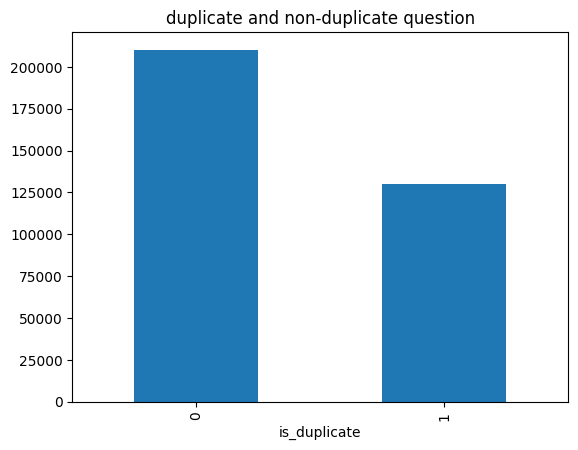

In [13]:
import matplotlib.pyplot as plt

print(df["is_duplicate"].value_counts())
print(">>>>>>>>>>>>>>>>>>>>>>>>>>\n")

print((df["is_duplicate"].value_counts()/df["is_duplicate"].count())*100)
print("<<<<<<<<<<<<<<<<<<<<<<<<<<\n")

df["is_duplicate"].value_counts().plot(kind="bar",title="duplicate and non-duplicate question")
plt.show()

In [14]:
df = df.drop(['id', 'qid1', 'qid2'], axis=1)

df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
4,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


# Text Preprocessing

In [15]:
def preprocess_text(text):

    text = text.lower()

    text = text.translate(str.maketrans('', '', string.punctuation))

    text = re.sub(r'\d+', '', text)

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text.lower())  
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return ' '.join(tokens)

df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

df[['question1', 'question2']].head()

,question1,question2
0,step step guide invest share market india,step step guide invest share market
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...
2,increase speed internet connection using vpn,internet speed increased hacking dns
3,one dissolve water quikly sugar salt methane c...,fish would survive salt water
4,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...


In [16]:
df

,question1,question2,is_duplicate
0,step step guide invest share market india,step step guide invest share market,0
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0
2,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0
4,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1
...,...,...,...
340047,many keywords racket programming language late...,many keywords perl programming language latest...,0
340048,believe life death,true life death,1
340049,one coin,whats coin,0
340050,approx annual cost living studying uic chicago...,little hairfall problem want use hair styling ...,0


# Feature Engineering: Jaccard + TF-IDF

In [17]:
def jaccard_similarity(q1, q2):
    a = set(q1.split())
    b = set(q2.split())

    if len(a) == 0 and len(b) == 0:
        return 1.0
    elif len(a) == 0 or len(b) == 0:
        return 0.0

    return len(a.intersection(b)) / len(a.union(b))

In [18]:
df['jaccard'] = df.apply(lambda row: jaccard_similarity(row['question1'], row['question2']), axis=1)

In [19]:
df

,question1,question2,is_duplicate,jaccard
0,step step guide invest share market india,step step guide invest share market,0,0.833333
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,0.222222
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,0.222222
3,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,0.153846
4,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1,0.400000
...,...,...,...,...
340047,many keywords racket programming language late...,many keywords perl programming language latest...,0,0.750000
340048,believe life death,true life death,1,0.500000
340049,one coin,whats coin,0,0.333333
340050,approx annual cost living studying uic chicago...,little hairfall problem want use hair styling ...,0,0.000000


In [20]:
questions_combined = df['question1'].tolist() + df['question2'].tolist()

In [21]:
questions_combined

['step step guide invest share market india',
 'story kohinoor kohinoor diamond',
 'increase speed internet connection using vpn',
 'one dissolve water quikly sugar salt methane carbon di oxide',
 'astrology capricorn sun cap moon cap risingwhat say',
 'buy tiago',
 'good geologist',
 'use instead',
 'method find separation slits using fresnel biprism',
 'read find youtube comments',
 'make physics easy learn',
 'first sexual experience like',
 'laws change status student visa green card us compare immigration laws canada',
 'manipulation mean',
 'girls want friends guy reject',
 'many quora users posting questions readily answered google',
 'best digital marketing institution banglore',
 'rockets look white',
 'whats causing someone jealous',
 'questions ask quora',
 'mean every time look clock numbers',
 'tips making job interview process medicines',
 'web application',
 'society place much importance sports',
 'best way make money online',
 'prepare ca final law',
 'whats one thing 

In [22]:
tfidf_vectorizer = TfidfVectorizer(min_df=1, max_df=0.95, max_features=500)

In [23]:
tfidf_matrix = tfidf_vectorizer.fit_transform(questions_combined)

In [24]:
tfidf_matrix.shape

(680104, 500)

In [25]:
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=tfidf_vectorizer.get_feature_names_out())

In [26]:
num_questions = len(df)
tfidf_question1 = tfidf_matrix[:num_questions, :]
tfidf_question2 = tfidf_matrix[num_questions:, :]

In [27]:
tfidf_question1_df = pd.DataFrame.sparse.from_spmatrix(tfidf_question1)
tfidf_question2_df = pd.DataFrame.sparse.from_spmatrix(tfidf_question2)

In [28]:
tfidf_question1_df.columns = [f'tfidf_q1_{i}' for i in range(tfidf_question1_df.shape[1])]
tfidf_question2_df.columns = [f'tfidf_q2_{i}' for i in range(tfidf_question2_df.shape[1])]

In [29]:
tfidf_question1_df

,tfidf_q1_0,tfidf_q1_1,tfidf_q1_2,tfidf_q1_3,tfidf_q1_4,tfidf_q1_5,tfidf_q1_6,tfidf_q1_7,tfidf_q1_8,tfidf_q1_9,...,tfidf_q1_490,tfidf_q1_491,tfidf_q1_492,tfidf_q1_493,tfidf_q1_494,tfidf_q1_495,tfidf_q1_496,tfidf_q1_497,tfidf_q1_498,tfidf_q1_499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
tfidf_question2_df

,tfidf_q2_0,tfidf_q2_1,tfidf_q2_2,tfidf_q2_3,tfidf_q2_4,tfidf_q2_5,tfidf_q2_6,tfidf_q2_7,tfidf_q2_8,tfidf_q2_9,...,tfidf_q2_490,tfidf_q2_491,tfidf_q2_492,tfidf_q2_493,tfidf_q2_494,tfidf_q2_495,tfidf_q2_496,tfidf_q2_497,tfidf_q2_498,tfidf_q2_499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.352771,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.588356,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df = pd.concat([df, tfidf_question1_df, tfidf_question2_df], axis=1)

In [32]:
df

,question1,question2,is_duplicate,jaccard,tfidf_q1_0,tfidf_q1_1,tfidf_q1_2,tfidf_q1_3,tfidf_q1_4,tfidf_q1_5,...,tfidf_q2_490,tfidf_q2_491,tfidf_q2_492,tfidf_q2_493,tfidf_q2_494,tfidf_q2_495,tfidf_q2_496,tfidf_q2_497,tfidf_q2_498,tfidf_q2_499
0,step step guide invest share market india,step step guide invest share market,0,0.833333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,0.222222,0,0,0,0,0,0,...,0,0,0,0.352771,0,0,0,0,0,0
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,0.222222,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,0.153846,0,0,0,0,0,0,...,0,0,0,0.588356,0,0,0,0,0,0
4,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1,0.400000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340047,many keywords racket programming language late...,many keywords perl programming language latest...,0,0.750000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340048,believe life death,true life death,1,0.500000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340049,one coin,whats coin,0,0.333333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340050,approx annual cost living studying uic chicago...,little hairfall problem want use hair styling ...,0,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df.drop(columns=['question1', 'question2'], inplace=True)

In [34]:
df

,is_duplicate,jaccard,tfidf_q1_0,tfidf_q1_1,tfidf_q1_2,tfidf_q1_3,tfidf_q1_4,tfidf_q1_5,tfidf_q1_6,tfidf_q1_7,...,tfidf_q2_490,tfidf_q2_491,tfidf_q2_492,tfidf_q2_493,tfidf_q2_494,tfidf_q2_495,tfidf_q2_496,tfidf_q2_497,tfidf_q2_498,tfidf_q2_499
0,0,0.833333,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.222222,0,0,0,0,0,0,0,0,...,0,0,0,0.352771,0,0,0,0,0,0
2,0,0.222222,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.153846,0,0,0,0,0,0,0,0,...,0,0,0,0.588356,0,0,0,0,0,0
4,1,0.400000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340047,0,0.750000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340048,1,0.500000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340049,0,0.333333,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340050,0,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train/Test Split

In [35]:
X = df.drop(columns=['is_duplicate'])
y = df['is_duplicate']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X_train.shape

(272041, 1001)

In [38]:
X_test.shape

(68011, 1001)

In [39]:
y_train.shape

(272041,)

In [40]:
y_test.shape

(68011,)

# ML Models

# Model 1: Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy (Random Forest): 0.7847407037096941
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     42043
           1       0.72      0.71      0.72     25968

    accuracy                           0.78     68011
   macro avg       0.77      0.77      0.77     68011
weighted avg       0.78      0.78      0.78     68011



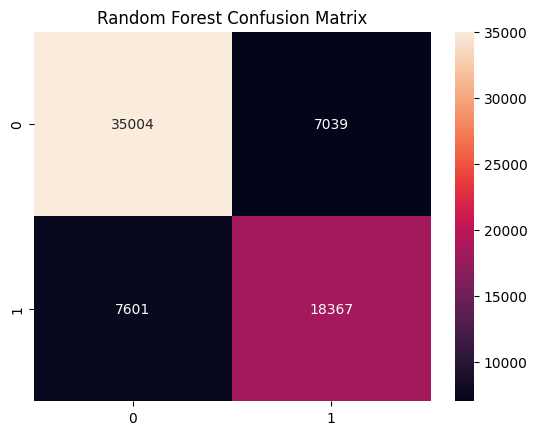

In [52]:
y_pred_rf = rf.predict(X_test)
print("Accuracy (Random Forest):", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d')
plt.title("Random Forest Confusion Matrix")
plt.show()

# Model 2: XGBoost

Accuracy (XGBoost): 0.7570393024657776
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     42043
           1       0.71      0.61      0.66     25968

    accuracy                           0.76     68011
   macro avg       0.75      0.73      0.73     68011
weighted avg       0.75      0.76      0.75     68011



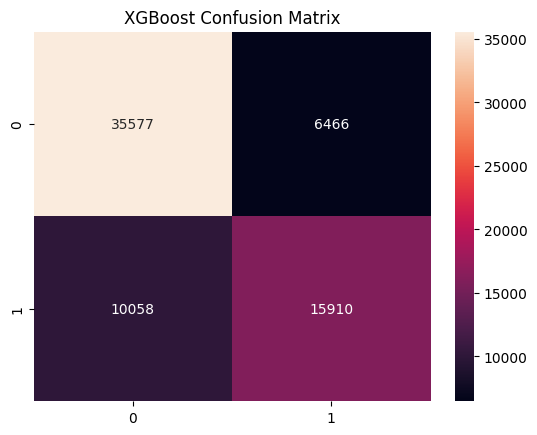

In [59]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train);
y_pred_xgb = xgb_model.predict(X_test)
print("Accuracy (XGBoost):", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d')
plt.title("XGBoost Confusion Matrix")
plt.show()